# Fitting Pure component parameters for Furfuryl Alcohol

In [1]:
import numpy as np
from scipy.optimize import minimize, least_squares
from epcsaftpy import component, pcsaft
import matplotlib.pyplot as plt
from pandas import read_excel

**Experimental liquid density from** <br />
H. Guerrero, C. Lafuente, F. Royo, L. Lomba, B. Giner. Energy & Fuels, 25(7), 3009–3013 (2011). (https://doi.org/10.1021/ef200653s) <br /> <br />
**Experimental saturation pressure from** <br />
L. Negadi, I. Mokbel, N. Chiali-Baba-Ahmed, L. Kara-Zaitri. J. Chem. Thermodyn., 70, 233-238 (2014). (https://doi.org/10.1016/j.jct.2013.10.039) <br />
W. Tai, H. Lee, M. Lee. Fluid Phase Equilib., 384, 134-142 (2014). (https://doi.org/10.1016/j.jct.2013.10.039)

In [2]:
Dexp_rho = read_excel('data_exp/FApure.xlsx', 'rho')
Dexp_psat = read_excel('data_exp/FApure.xlsx', 'psat')

    
Tr   = np.array(Dexp_rho.iloc[:,0])         # K
rhol = np.array(Dexp_rho.iloc[:,1])         # g/cm3
Pr   = np.array(Dexp_rho.iloc[:,2])*1e5     # Pa
Tsat = np.array(Dexp_psat.iloc[:,0])        # K
Psat = np.array(Dexp_psat.iloc[:,1])*1e5    # Pa

Minimization using the Levenberg–Marquardt algorithm.

In [3]:
# Objective function
def fobj_lvq(inc):
    ms, sigma, eps, kappaAB, eAB = inc**2  # inc**2, to avoid negative value in the parameters
    pure = component(ms = ms, sigma = sigma , eps = eps, 
                     kappaAB = kappaAB, eAB = eAB, sites = [0, 1, 2], Mw = 98.1014)
    eos = pcsaft(pure)
    
    #Pure component pressure
    Psat_cal = np.zeros_like(Psat) 
    rhol_cal = np.zeros_like(rhol)
    
    n1 = len(Psat)
    n2 = len(rhol)
    if max(Psat) < eos.Pc:
        for i in range(n1):
            Psat_cal[i], _, _ = eos.psat(Tsat[i])

    for i in range(n2):
        rho = eos.density(Tr[i], Pr[i], "L")
        rhol_cal[i] = pure.Mw * rho * 1e-6

    
    # error for saturation pressure and densities
    error1 = (Psat_cal/Psat - 1)/n1
    error2 = (rhol_cal/rhol - 1)/n2
    return np.append(error1, error2)

# initial guess
inc0 = np.array([2.313, 4.038, 320.38, 0.001, 3200.0])  # HMF parameters as a initial guess
method = 'lm'
out = least_squares(fobj_lvq, np.sqrt(inc0), method = method)

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("cost     :", out.cost)
print("_________________________________")
ms0, sigma0, eps0, kappaAB0, eAB0 = out.x**2
print("ms0      :", ms0)
print("sigma0   :", sigma0)
print("eps0     :", eps0)
print("kappaAB0 :", kappaAB0)
print("eAB0     :", eAB0)

RESULTS
_________________________________
message  : `ftol` termination condition is satisfied.
success  : True
cost     : 4.669227299367269e-06
_________________________________
ms0      : 4.360663513430515
sigma0   : 3.004938983714979
eps0     : 218.35318814628044
kappaAB0 : 0.14616501151839814
eAB0     : 1834.352485022771


# Pure diagrams for Furfuryl Alcohol

In [4]:
FA = component('Furfuryl Alcohol', ms = 4.360664, sigma = 3.004939 , eps = 218.35319, 
               kappaAB = 0.14617, eAB = 1834.352, sites = [0, 1, 2], Mw = 98.1014)
saft = pcsaft(FA)

# VLE calculation
T0 = 200.
Tf = saft.Tc
n = 200                                                 # Number of points
Tsat_cal  = np.linspace(T0, Tf, n)                      # Temperature vector
Psat_cal  = np.zeros_like(Tsat_cal)                     # Vector to save the information
for i in range(n - 1):                   
    Psat_cal[i], _, _  = saft.psat(Tsat_cal[i])         # Solving and saving the VLE
Psat_cal[-1] = saft.Pc                                  # Saving the critical point

# Isobaric calculation
Pset = list(set(Pr.tolist()))                           # Identify the different pressure
nP = len(Pset)
T0 = 250.
Tf = 350.
n = 50                                                  # Number of points
Tr_cal  = np.linspace(T0, Tf, n)                        # Temperature vector
rhol_cal  = np.zeros([n, nP])                           # Vector to save the information
for i in range(n): 
    for j in range(nP):
        rhol_cal[i, j] = saft.density(Tr_cal[i], Pset[j], "L") # Solving the density


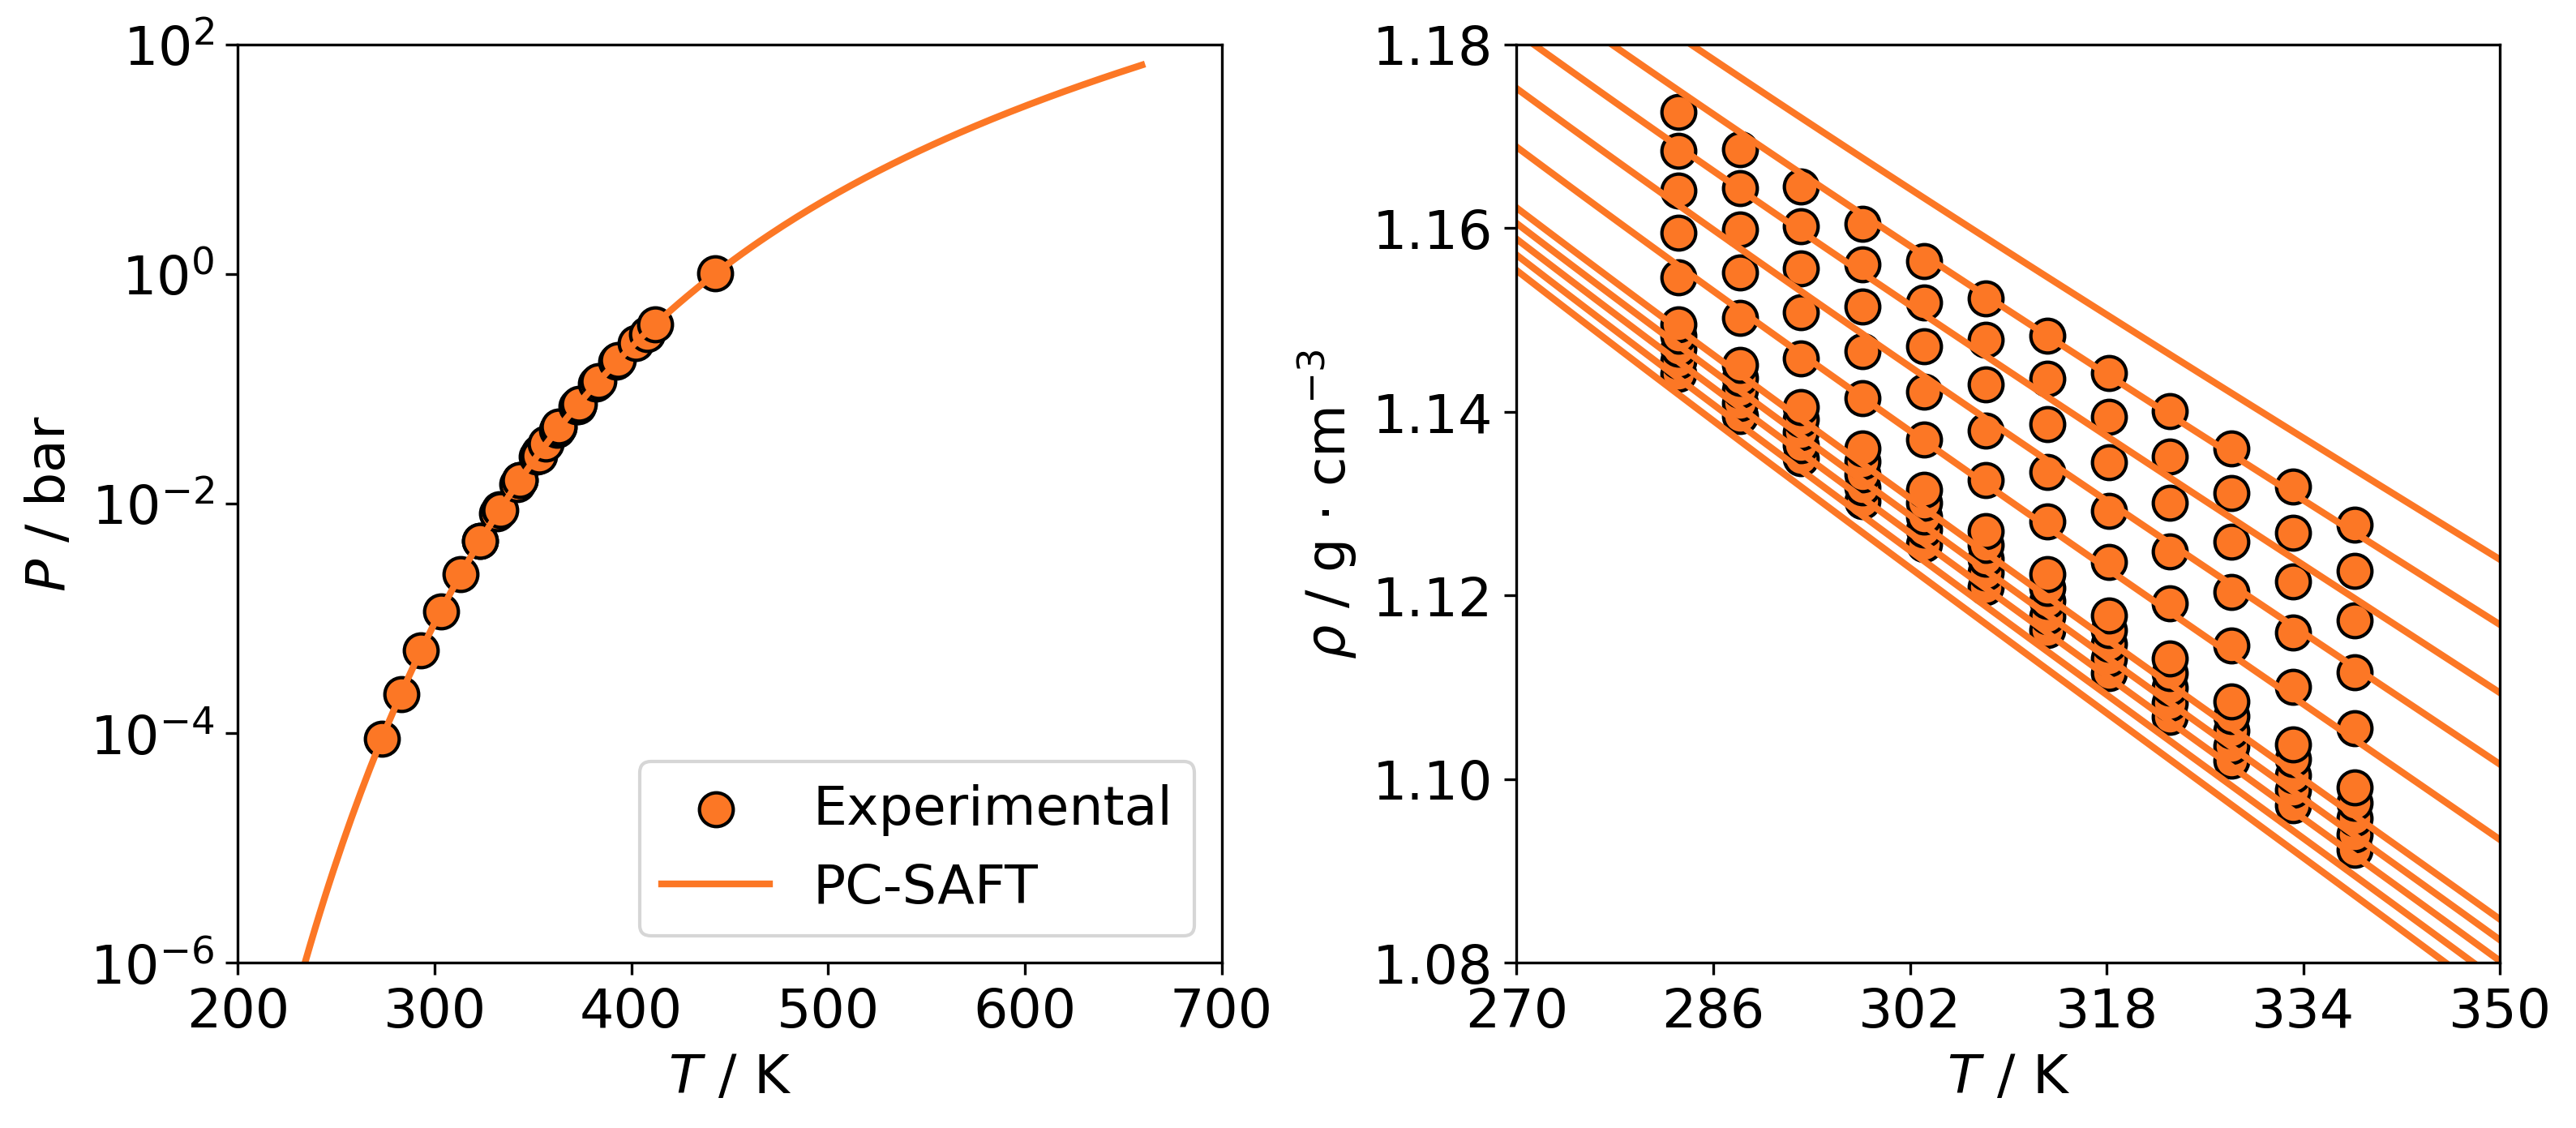

In [5]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)


colorVLE = "#FC7725"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)


ax = axs[0]
ax.scatter(Tsat, Psat * 1e-5, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.plot(Tsat_cal, Psat_cal * 1e-5, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")

ax.set_xlabel('$T$ / K')
ax.set_ylabel('$P$ / bar')
ax.axis([200, 700., 1e-6, 100.])

ax.set_yscale('log')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 6))
ax.legend()

ax = axs[1]
ax.scatter(Tr, rhol, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.plot(Tr_cal, saft.Mw * rhol_cal * 1e-6, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")

ax.set_xlabel('$T$ / K')
ax.set_ylabel(r'$\rho$ / g $\cdot$ cm$^{-3}$')
ax.axis([270, 350., 1.08, 1.18])

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 6))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 6))


plt.show()